In [1]:
import pandas as pd 
import numpy as np
import pickle
from sklearn.cluster import KMeans  
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


In [2]:
# Read in customer_scaled.csv
df = pd.read_csv("../data/customer_scaled.csv")

# Build X, y (target -> y), drop churn if present
df = df.drop(columns=["churn"], errors="ignore")
df.head()

,price,quantity,total_value,age,tenure_months
0,-0.331414,-0.705075,-0.437972,-0.111310,0.419732
1,1.210873,-0.705075,0.417196,0.638823,0.823382
2,1.210873,0.709318,1.583334,-0.636403,-0.272241
3,-0.331414,-1.412272,-0.593457,-0.036297,1.515354
4,-0.331414,0.709318,-0.127002,1.388956,1.284697


In [3]:
# evaluate different k values and PCA components using intertia and silhouette score
def eval_grid(df, k_list=range(2,9), ncomp_list=(None,2,3,4)):
    rows=[]
    for nc in ncomp_list:
        Z = PCA(n_components=nc, svd_solver="full").fit_transform(df) if nc else df
        for k in k_list:
            km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(Z)
            labels = km.labels_
            rows.append({
                "k": k,
                "n_components": (nc if nc else 0),   # 0 = no PCA
                "inertia": km.inertia_,
                "silhouette": silhouette_score(Z, labels)
            })
    return pd.DataFrame(rows)

res = eval_grid(df, k_list=range(2,10), ncomp_list=(None,2,3,4,5))
# Higher is better for silhouette 
best = res.sort_values(["silhouette"], ascending=[False]).head(5)
print(best)

    k  n_components       inertia  silhouette
8   2             2  12321.562488    0.528214
16  2             3  20220.666633    0.419340
9   3             2   7787.183432    0.400370
10  4             2   6178.041399    0.391769
24  2             4  27842.106457    0.355954


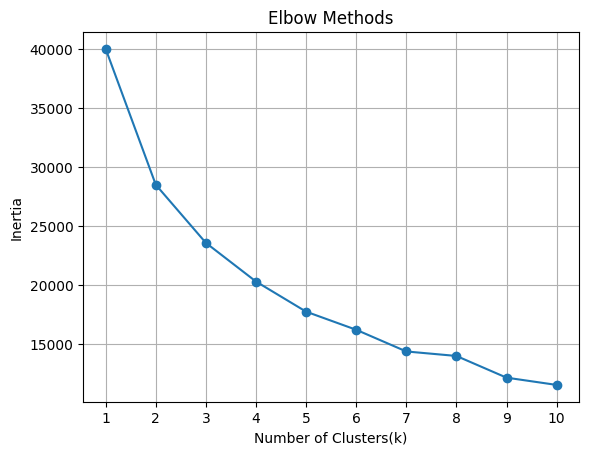

In [4]:
# elbow method to find optimal k
inertia_values = []
k_values = range(1,11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia_values.append(kmeans.inertia_)
plt.plot(k_values, inertia_values, marker = 'o')
plt.title('Elbow Methods')
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.xticks(k_values)
plt.show()

In [5]:
# From above, choose k=3 and fit final model
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model = kmeans_model.fit(df)

In [6]:
# add cluster labels to the original dataframe
df['cluster'] = kmeans_model.labels_
df.head()

,price,quantity,total_value,age,tenure_months,cluster
0,-0.331414,-0.705075,-0.437972,-0.111310,0.419732,2
1,1.210873,-0.705075,0.417196,0.638823,0.823382,0
2,1.210873,0.709318,1.583334,-0.636403,-0.272241,1
3,-0.331414,-1.412272,-0.593457,-0.036297,1.515354,2
4,-0.331414,0.709318,-0.127002,1.388956,1.284697,0


In [7]:
# Perform PCA to reduce dimensions for visualization
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(df)
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]

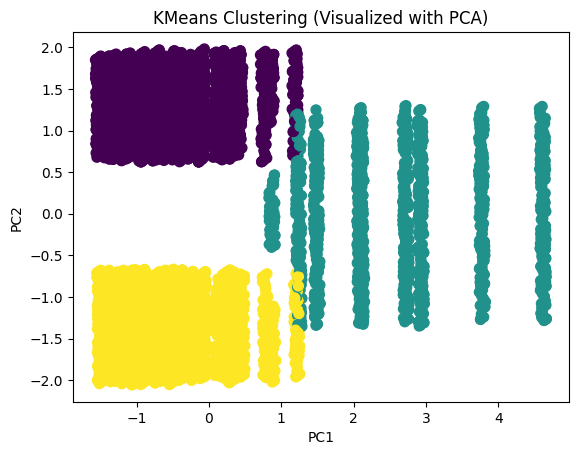

In [8]:
# Visualize the clusters
plt.scatter(df['PC1'],df['PC2'], c=df['cluster'], s = 50, cmap='viridis')
plt.title('KMeans Clustering (Visualized with PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [10]:
# Save the model
with open("../models/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans_model, f)

print("Model saved to models/kmeans_model.pkl")

Model saved to models/kmeans_model.pkl
